### Importing Libraries

In [481]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
pd.options.display.max_rows = 2500

In [362]:
# CODING TEST:
# This test is to measure how candidate can use Python to do data collecting, cleaning and modeling
# For modeling part, we hope candidate can pay more attention to how to measure if this model is good and how to improve it.

In [363]:
# Project overview
# We want to to use some econ variables to predict S&P 500 index

In [364]:
# STEP 1:
# Data collecting
# Now we need to recent 10-years data of S&P500, CPI(consumer price index), UR(unemployment rate), PMI(purchasing manager index)
# , Nikkei 225 index, VIX data(you need to shift this data by 15 mins), EFFR(you can find it from Fedfund) and VVIX data.

In [365]:
# Write you data collecting code below
data_folder = './data/'

### S&P500
#### Source: https://finance.yahoo.com/quote/%5EGSPC/history?period1=1242878400&period2=1558411200&interval=1d&filter=history&frequency=1d

In [568]:
SP500 = pd.read_csv(data_folder+'S&P500_source.csv')
SP500 = SP500[['Date','Close']]
SP500.columns = ['Date','S&P500']
SP500['Date'] = pd.to_datetime(SP500['Date'])
SP500.to_csv(data_folder+'S&P500.csv',index = False)
SP500.head()

,Date,S&P500
0,2009-05-21,888.330017
1,2009-05-22,887.000000
2,2009-05-26,910.330017
3,2009-05-27,893.059998
4,2009-05-28,906.830017


### Consumer Price Index
#### Source: https://data.oecd.org/price/inflation-cpi.htm

In [569]:
CPI = pd.read_csv(data_folder+'CPI_source.csv')
CPI = CPI[CPI['LOCATION']=='USA'][['TIME','Value']]#Took the decision to use only US data
CPI.columns = ['Date','CPI']
CPI['Date'] = pd.to_datetime(CPI['Date'])
CPI.to_csv(data_folder+'CPI.csv',index = False) 
CPI.head()

,Date,CPI
3291,2009-03-01,-0.383556
3292,2009-04-01,-0.736886
3293,2009-05-01,-1.281436
3294,2009-06-01,-1.426776
3295,2009-07-01,-2.097161


### Unemployement Rate
#### Source: https://data.bls.gov/timeseries/lns14000000

In [570]:
UR_tab = pd.read_csv(data_folder+'UR_source.csv',sep=';')
#Convert the matrix into a dataframe
years = np.repeat(UR_tab.Year.values,[12]*11)
months = ['01','02','03','04','05','06','07','08','09','10','11','12']*11
values = UR_tab.drop(columns = ['Year']).values.ravel()
data = {'year': years, 'month':months, 'UR':values}
UR = pd.DataFrame(data = data)
#Add date column
UR['Date'] = UR.apply(lambda x: str(x['year'])+'-'+x['month'],axis = 1)
UR = UR[['Date','UR']]
UR['Date'] = pd.to_datetime(UR['Date'])
UR.to_csv(data_folder+'UR.csv',index = False)
UR.head()

,Date,UR
0,2009-01-01,"7,8"
1,2009-02-01,"8,3"
2,2009-03-01,"8,7"
3,2009-04-01,"9,0"
4,2009-05-01,"9,4"


### Purchasing Management Index

In [571]:
PMI = pd.read_csv(data_folder+'PMI_source.csv',sep=';')
PMI.columns =['Date','PMI']
PMI['Date'] = pd.to_datetime(PMI['Date'])
PMI = PMI[PMI['Date']>=datetime.strptime('2009-01-01','%Y-%m-%d')]
PMI.to_csv(data_folder+'PMI.csv',index = False)
PMI.head()

,Date,PMI
732,2009-01-01,"34,9"
733,2009-02-01,"35,5"
734,2009-03-01,"36,0"
735,2009-04-01,"39,5"
736,2009-05-01,"41,7"


### Nikkei 225 index
#### Source: https://finance.yahoo.com/quote/%5EN225/history?period1=1242792000&period2=1558324800&interval=1d&filter=history&frequency=1d

In [572]:
Nikkei225 = pd.read_csv(data_folder+'Nikkei225_source.csv')
Nikkei225 = Nikkei225[['Date','Close']]
Nikkei225.columns = ['Date','Nikkei225']
Nikkei225['Date'] = pd.to_datetime(Nikkei225['Date'])
Nikkei225.to_csv(data_folder+'Nikkei225.csv',index = False)
Nikkei225.head()

,Date,Nikkei225
0,2009-05-20,9344.639648
1,2009-05-21,9264.150391
2,2009-05-22,9225.809570
3,2009-05-25,9347.000000
4,2009-05-26,9310.809570


### Volatility Index
#### Source: https://finance.yahoo.com/quote/%5EVIX/history?period1=1242792000&period2=1558324800&interval=1d&filter=history&frequency=1d

In [573]:
VIX = pd.read_csv(data_folder+'VIX_source.csv')
VIX = VIX[['Date','Close']]
VIX.columns = ['Date','VIX']
VIX['Date'] = pd.to_datetime(VIX['Date'])
VIX.to_csv(data_folder+'VIX.csv',index = False)
VIX.head()

,Date,VIX
0,2009-05-20,29.030001
1,2009-05-21,31.350000
2,2009-05-22,32.630001
3,2009-05-26,30.620001
4,2009-05-27,32.360001


### Effective Federal Fund Rate
#### Source: https://apps.newyorkfed.org/markets/autorates/fed-funds-search-result-page

In [574]:
#EFFR
#Source: https://apps.newyorkfed.org/markets/autorates/fed-funds-search-result-page
EFFR = pd.read_csv(data_folder+'EFFR_source.csv',sep=';')
EFFR.columns = ['Date','Volume','EFFR']
EFFR.drop(columns = ['Volume'],inplace = True)
EFFR = EFFR.iloc[0:2514]
def convert_date(date):
    try:
        return(datetime.strptime(date,'%d/%m/%Y'))
    except:
        return(datetime.strptime(date,'%Y-%m-%d[r]'))
EFFR['Date'] = EFFR['Date'].apply(lambda x: convert_date(x))
EFFR.to_csv(data_folder+'EFFR.csv',index = False)
EFFR.head()


,Date,EFFR
0,2019-05-20,"2,39"
1,2019-05-17,"2,39"
2,2019-05-16,"2,39"
3,2019-05-15,"2,4"
4,2019-05-14,"2,38"


### VIX Votality Index
#### Source: https://finance.yahoo.com/quote/%5EVVIX/history?period1=1242792000&period2=1558324800&interval=1d&filter=history&frequency=1d

In [575]:
#VVIX
#Source: https://finance.yahoo.com/quote/%5EVVIX/history?period1=1242792000&period2=1558324800&interval=1d&filter=history&frequency=1d
VVIX = pd.read_csv(data_folder+'VVIX_source.csv')
VVIX = VVIX[['Date','Close']]
VVIX.columns = ['Date','VVIX']
VVIX['Date'] = pd.to_datetime(VVIX['Date'])
VVIX.to_csv(data_folder+'VVIX.csv',index = False)
VVIX.head()

,Date,VVIX
0,2009-05-20,77.449997
1,2009-05-21,84.690002
2,2009-05-22,87.279999
3,2009-05-26,91.230003
4,2009-05-27,90.860001


In [576]:
# STEP 2:
# Data processing
# please concat all dataframes you just collected, and do the following processing
#   1. handle Nan value.
#   2. handle outlier. (you can use MAD, 3 sigma or other methods)

## Data Processing
#### Set Date as index

In [577]:
# Write you data processing code below
SP500.set_index('Date',inplace = True)
CPI.set_index('Date',inplace = True)
UR.set_index('Date',inplace = True)
PMI.set_index('Date',inplace = True)
Nikkei225.set_index('Date',inplace = True)
VIX.set_index('Date',inplace = True)
EFFR.set_index('Date',inplace = True)
VVIX.set_index('Date',inplace = True)

#### Concatenate all the databases

In [578]:
data = pd.concat([SP500,CPI,UR,PMI,Nikkei225,VIX,EFFR,VVIX],axis = 1)

In [579]:
data.head(10)

,S&P500,CPI,UR,PMI,Nikkei225,VIX,EFFR,VVIX
Date,,,,,,,,
2009-01-01,NaN,NaN,"7,8","34,9",NaN,NaN,NaN,NaN
2009-02-01,NaN,NaN,"8,3","35,5",NaN,NaN,NaN,NaN
2009-03-01,NaN,-0.383556,"8,7","36,0",NaN,NaN,NaN,NaN
2009-04-01,NaN,-0.736886,"9,0","39,5",NaN,NaN,NaN,NaN
2009-05-01,NaN,-1.281436,"9,4","41,7",NaN,NaN,NaN,NaN
2009-05-20,NaN,NaN,NaN,NaN,9344.639648,29.030001,"0,14",77.449997
2009-05-21,888.330017,NaN,NaN,NaN,9264.150391,31.350000,"0,17",84.690002
2009-05-22,887.000000,NaN,NaN,NaN,9225.809570,32.630001,"0,17",87.279999
2009-05-25,NaN,NaN,NaN,NaN,9347.000000,NaN,NaN,NaN


In [580]:
data.shape[0]

2652

#### Filling the monthly features

In [581]:
data[['CPI','UR','PMI']] = data[['CPI','UR','PMI']].ffill()

#### Drop the remaining NaNs

In [582]:
data.dropna(inplace = True)

In [583]:
data.shape[0]

2356

#### Replace str values by floats

In [584]:
data.UR = data.UR.apply(lambda x: float(x.replace(',','.')))
data.PMI = data.PMI.apply(lambda x:float(x.replace(',','.')))
data.EFFR = data.EFFR.apply(lambda x:float(x.replace(',','.')))

### Outliers handling
#### S&P500

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


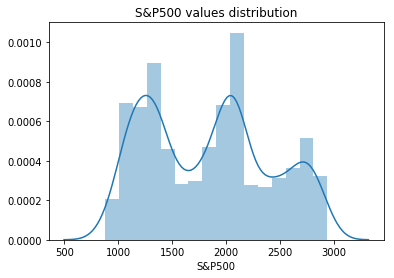

In [585]:
sns.distplot(data['S&P500'])
plt.title('S&P500 values distribution')
plt.show()

According to the distribution there are no outliers

#### CPI

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


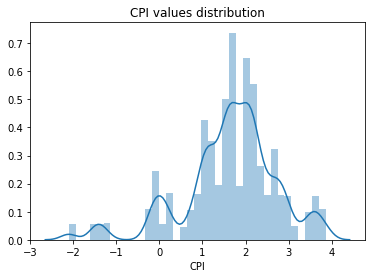

In [586]:
sns.distplot(data.CPI)
plt.title('CPI values distribution')
plt.show()

There are some outliers in the negative values. I will drop those under 3 standard deviation.

In [587]:
CPIstd = data.CPI.std()
CPImu = data.CPI.mean()
print('number of rows below 3 std:',data[(data.CPI < CPImu-3*CPIstd)].shape[0])

number of rows below 3 std: 21


In [588]:
data = data[(data.CPI >= CPImu-3*CPIstd)]

In [589]:
print('number of rows above 3 std:',data[(data.CPI > CPImu+3*CPIstd)].shape[0])

number of rows above 3 std: 0


#### Unemployement Rate

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


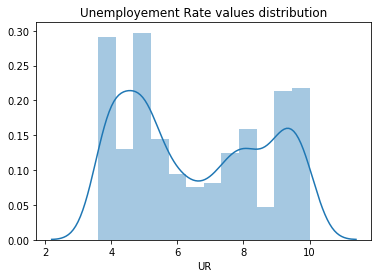

In [591]:
sns.distplot(data.UR)
plt.title('Unemployement Rate values distribution')
plt.show()

No outlier appearing in the distribution

#### PMI

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


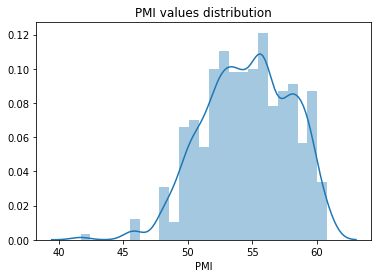

In [593]:
sns.distplot(data.PMI)
plt.title('PMI values distribution')
plt.show()

In [594]:
PMIstd = data.PMI.std()
PMImu = data.PMI.mean()
print('number of rows below 3 std:',data[(data.PMI < PMImu-3*PMIstd)].shape[0])

number of rows below 3 std: 6


In [595]:
data = data[(data.PMI >= PMImu-3*PMIstd)]

In [597]:
print('number of rows above 3 std:',data[(data.PMI > PMImu+3*PMIstd)].shape[0])

number of rows above 3 std: 0


#### Nikkei 225 index

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[]

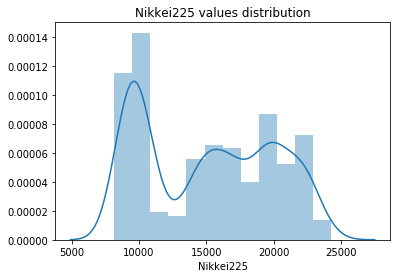

In [598]:
sns.distplot(data.Nikkei225)
plt.title('Nikkei225 values distribution')
plt.plot()

No outliers appearing in the distribution

#### VIX

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


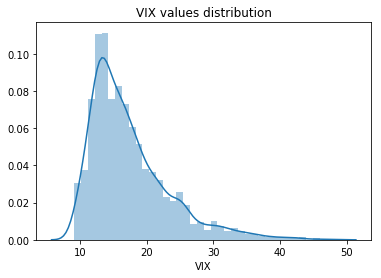

In [599]:
sns.distplot(data.VIX)
plt.title('VIX values distribution')
plt.show()

The distribution is very clean I won't drop any outlier

#### EFFR

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


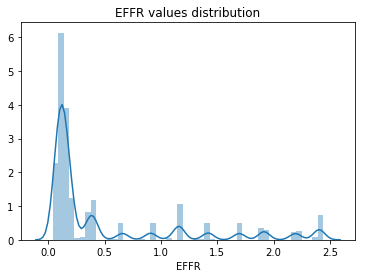

In [602]:
sns.distplot(data.EFFR)
plt.title('EFFR values distribution')
plt.show()

Due to the particularity of the distribution I won't drop any outlier

#### VVIX

C:\Users\antoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


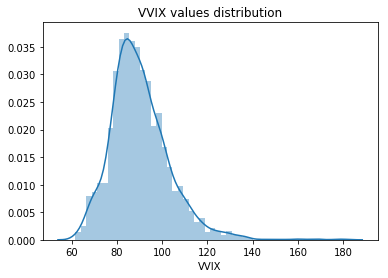

In [601]:
sns.distplot(data.VVIX)
plt.title('VVIX values distribution')
plt.show()

The distribution is very clean, no outliers. 

In [603]:
data.head()

,S&P500,CPI,UR,PMI,Nikkei225,VIX,EFFR,VVIX
Date,,,,,,,,
2009-06-01,942.869995,-1.426776,9.5,45.8,9677.750000,30.040001,0.21,84.230003
2009-06-02,944.739990,-1.426776,9.5,45.8,9704.309570,29.629999,0.20,83.820000
2009-06-03,931.760010,-1.426776,9.5,45.8,9741.669922,31.020000,0.21,84.889999
2009-06-04,942.460022,-1.426776,9.5,45.8,9668.959961,30.180000,0.20,81.260002
2009-06-05,940.090027,-1.426776,9.5,45.8,9768.009766,29.620001,0.21,82.110001


In [605]:
print('The first date of data is:',data.index.min())
print('The last date of data is:',data.index.max())

The first date of data is: 2009-06-01 00:00:00
The last date of data is: 2019-05-20 00:00:00


In [608]:
print('We have here',(data.index.max()-data.index.min()).days,'days of data which almost 10 years')

We have here 3640 days of data which almost 10 years


### Adding Feature and shifting

#### Adding return for S&P500 and Nikkei 225 and shifting everything to predict next day's return

In [609]:
data['S&P_return'] = data['S&P500']/data['S&P500'].shift(1) -1
data['Nikkei225_return_d1'] = (data.Nikkei225/data.Nikkei225.shift(1) -1).shift(1)
data['S&P_return_d1'] = data['S&P_return'].shift(1)
data[['CPI','UR','PMI','VIX','EFFR','VVIX']] = data[['CPI','UR','PMI','VIX','EFFR','VVIX']].shift(1)
data.head()

,S&P500,CPI,UR,PMI,Nikkei225,VIX,EFFR,VVIX,S&P_return,Nikkei225_return_d1,S&P_return_d1
Date,,,,,,,,,,,
2009-06-01,942.869995,NaN,NaN,NaN,9677.750000,NaN,NaN,NaN,NaN,NaN,NaN
2009-06-02,944.739990,-1.426776,9.5,45.8,9704.309570,30.040001,0.21,84.230003,0.001983,NaN,NaN
2009-06-03,931.760010,-1.426776,9.5,45.8,9741.669922,29.629999,0.20,83.820000,-0.013739,0.002744,0.001983
2009-06-04,942.460022,-1.426776,9.5,45.8,9668.959961,31.020000,0.21,84.889999,0.011484,0.003850,-0.013739
2009-06-05,940.090027,-1.426776,9.5,45.8,9768.009766,30.180000,0.20,81.260002,-0.002515,-0.007464,0.011484


In [610]:
data.dropna(inplace = True)

In [611]:
print('The final number of rows is:',data.shape[0])

The final number of rows is: 2327


In [329]:
# STEP 3:
# Modeling
# please use the linear regression and lasso regression to build the model, and compare the result of this two different method.
# If you have time, you can try bagging and boosting method to get a more robust model.

#### Define a functiun to split the data between train, validation and test set 

In [404]:
# Write you modeling code below
def train_val_test_split(X,Y,test_size,val=False,val_size=None):
    n = len(Y)
    if val:
        Y_train = Y[:int(n*(1-val_size-test_size))]
        Y_val = Y[int(n*(1-val_size-test_size)):int(n*(1-val_size-test_size))+int(n*val_size)]
        Y_test = Y[int(n*(1-val_size-test_size))+int(n*val_size):]
        X_train = X[:int(n*(1-val_size-test_size))]
        X_val = X[int(n*(1-val_size-test_size)):int(n*(1-val_size-test_size))+int(n*val_size)]
        X_test = X[int(n*(1-val_size-test_size))+int(n*val_size):]
        return([Y_train,X_train, Y_val, X_val, Y_test, X_test])
    else:
        Y_train = Y[:int(n*(1-test_size))]
        Y_test = Y[int(n*(1-test_size)):]
        X_train = X[:int(n*(1-test_size))]
        X_test = X[int(n*(1-test_size)):]
        return([Y_train, X_train, Y_test, X_test])

#### Define a function to compute the money made by investing 1 dollar at the begining of the testing period

In [422]:
def money_made(Y_pred, Y_test):
    true_pred = (np.sign(Y_pred) == np.sign(Y_test))
    val = 1
    for i in range(len(Y_test)):
        if true_pred[i]:
            val = val*(1+abs(Y_test[i]))
        else:
            val = val*(1-abs(Y_test[i]))
    return val

#### define X Covariates and Y the independent variable

In [456]:
Y = data['S&P_return'].values
X = data.drop(columns = ['S&P_return','S&P500','Nikkei225','Nikkei225_return']).values

In [617]:
print('begining of test set is:',data.index[int(len(Y)*0.8)+1])

begining of test set is: 2017-06-01 00:00:00


### Linear Regression

In [672]:
Y_train, X_train, Y_test, X_test = train_val_test_split(X,Y,0.2)

In [673]:
model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [674]:
Y_pred = model.predict(X_test)

In [675]:
r2_lin = r2_score(Y_test,Y_pred)
print('The R² score for this model is:',r2_lin)

The R² score for this model is: 0.10605669305600374


In [677]:
money_lin = money_made(Y_pred,Y_test)
print('Investing $1 the first if June 2017 will give now',money_lin,'$')

Investing $1 the first if June 2017 will give now 2.1925203345209545 $


### Lasso Regression

#### I run a validation test to find the best alpha

In [619]:
Y_train, X_train, Y_val, X_val, Y_test, X_test = train_val_test_split(X,Y,test_size = 0.2,val = True, val_size = 0.2)

In [620]:
alphas = np.array([0.0001,0.001,0.01,0.1,1,10,100,1000])

In [621]:
money = []
r2 = []
for alpha in alphas:
    model = Lasso(alpha = alpha,random_state = 12)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_val)
    r2.append(r2_score(Y_val,Y_pred))
    money.append(money_made(Y_pred,Y_val))

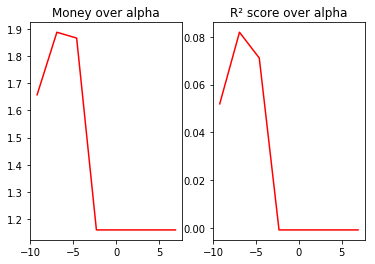

In [629]:
plt.subplot(1,2,1)
plt.plot(np.log(alphas),money,'r')
plt.title(('Money over alpha'))
plt.subplot(1,2,2)
plt.plot(np.log(alphas),r2,'r')
plt.title(('R² score over alpha'))
plt.show()

In [461]:
best_alpha = alphas[np.argmax(np.array(r2))]

In [678]:
print('The best alpha is:',best_alpha)

The best alpha is: 0.001


### Training the best model on the train + validation set

In [679]:
Y_train, X_train, Y_test, X_test = train_val_test_split(X,Y,0.2)

In [680]:
model = Lasso(alpha = best_alpha, random_state = 12)
model.fit(X_train,Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=12,
   selection='cyclic', tol=0.0001, warm_start=False)

In [681]:
Y_pred = model.predict(X_test)

In [682]:
r2_las = r2_score(Y_test,Y_pred)
print('The R² score for this model is:',r2_las)

The R² score for this model is: 0.10803186021899625


In [683]:
money_las = money_made(Y_pred,Y_test)
print('The money made with this model is $',money_las)

The money made with this model is $ 2.3299686314013215


### Bagging Regressor

#### I will only try the bagging regressor with decision tree and do a validation test to find the best number of trees

In [637]:
Y_train, X_train, Y_val, X_val, Y_test, X_test = train_val_test_split(X,Y,test_size = 0.2,val = True, val_size = 0.2)

In [638]:
nb_estimators = np.arange(10,200,10)

In [643]:
r2 = []
for n in nb_estimators: 
    model = BaggingRegressor(n_estimators = n,random_state = 12)
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_val)
    r2.append(r2_score(Y_val, Y_pred))

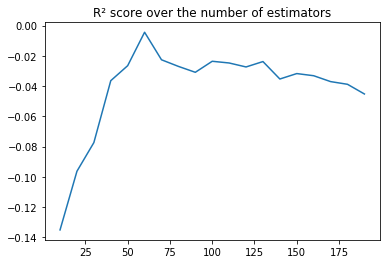

In [644]:
plt.plot(nb_estimators, r2)
plt.title('R² score over the number of estimators')
plt.show()

In [645]:
best_n = nb_estimators[np.argmax(r2)]

In [646]:
print('The best number of estimator is:', best_n)

The best number of estimator is: 60


#### I now train the best model on the whole training set

In [684]:
Y_train, X_train, Y_test, X_test = train_val_test_split(X,Y,0.2)

In [685]:
model = BaggingRegressor(n_estimators = best_n, random_state = 12)
model.fit(X_train,Y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=12,
         verbose=0, warm_start=False)

In [686]:
Y_pred = model.predict(X_test)

In [689]:
r2_bag = r2_score(Y_test,Y_pred)
print('The R² score for this model is:',r2_bag)

The R² score for this model is: 0.08374729222238819


In [690]:
money_bag = money_made(Y_pred,Y_test)
print('The money made with this model is:',money_bag)

The money made with this model is: 2.4648655048763275


### Gradient Boosting

I will perform a grid search with Gradient Boosting to find the best trade off between the learning rate and the number of estimators

In [653]:
Y_train, X_train, Y_val, X_val, Y_test, X_test = train_val_test_split(X,Y,test_size = 0.2,val = True, val_size = 0.2)

In [654]:
nb_estimators = np.arange(10,110,10)
learning_rates = np.array([0.001,0.01,0.1,1,10,100])

In [662]:
r2 = np.zeros((len(nb_estimators),len(learning_rates)))
for i in range(len(nb_estimators)):
    for j in range(len(learning_rates)):
        model = GradientBoostingRegressor(n_estimators = nb_estimators[i],learning_rate = learning_rates[j],random_state = 630)
        model.fit(X_train,Y_train)
        Y_pred = model.predict(X_val)
        r2[i,j] = r2_score(Y_val,Y_pred)

C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:282: RuntimeWarning: overflow encountered in square
  np.sum(sample_weight * ((y - pred.ravel()) ** 2.0)))
C:\Users\antoi\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\antoi\Anaconda3\lib\site-packages\sklearn\metrics\regression.py:538: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


In [663]:
best_n = nb_estimators[np.unravel_index(np.argmax(r2, axis=None), r2.shape)[0]]
print('The best number of estimators is:',best_n)

The best number of estimators is: 10


In [664]:
best_rate = learning_rates[np.unravel_index(np.argmax(r2, axis=None), r2.shape)[1]]
print('The best learning rate is:',best_rate)

The best learning rate is: 0.1


#### We now train the best model on the whole training set

In [691]:
Y_train, X_train, Y_test, X_test = train_val_test_split(X,Y,0.2)

In [692]:
model = GradientBoostingRegressor(n_estimators = best_n, learning_rate = best_rate,random_state = 630)
model.fit(X_train,Y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=10, presort='auto', random_state=630,
             subsample=1.0, verbose=0, warm_start=False)

In [693]:
Y_pred = model.predict(X_test)

In [696]:
r2_grad = r2_score(Y_test,Y_pred)
print('The R² score for this model is:',r2_grad)

The R² score for this model is: 0.10423488009750992


In [697]:
money_grad = money_made(Y_pred,Y_test)
print('The money made with this model is:',money_grad)

The money made with this model is: 2.530627762427387


### Models Comparison

In [706]:
r2_scores = [r2_lin, r2_las, r2_bag, r2_grad]
moneys = [money_lin, money_las, money_bag, money_grad]
models = ['Linear', 'Lasso', 'Bagging', 'Gradient Boosting']

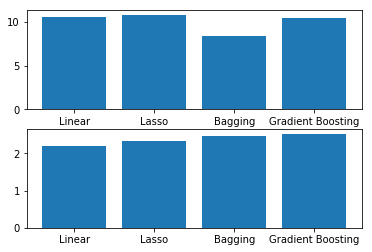

In [709]:
x = np.arange(4)
plt.subplot(211)
plt.bar(x, height= r2_scores) 
plt.xticks(x, models)
plt.subplot(212)
plt.bar(x, height = moneys)
plt.xticks(x, models)
plt.show()

The model that has the best R² score is the lasso regression which mean that it explains the the variance the best. And the model with which we make the more money is the gradient boosting.